### Introduction
Briefly describe the project, its objectives, and the dataset you will use.

### Setup and Imports
Import necessary libraries (`tensorflow`, `numpy`, `matplotlib`, etc.).

In [15]:
'''Setup and Imports'''
import numpy as np
import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# If the warning persists, you might try using the legacy optimizer as follows:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras import layers, models # for defining the generator and discriminator networks
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for data visualization
from PIL import Image # for loading images
import matplotlib.image as mpimg # for loading images
import matplotlib.pyplot as plt
import pandas as pd # for data visualization
import sklearn # for any additional machine learning utilities
from sklearn.preprocessing import MultiLabelBinarizer # for one-hot encoding of ingredient labels
from sklearn.model_selection import train_test_split # for splitting the dataset
import skimage # for image processing
from skimage.transform import resize
from skimage.io import imread
import os

### Dataset Loading and Preprocessing
- Load your dataset of smoothie images.
- Preprocess images (resizing, normalization).
- Split the dataset into training and testing sets.

This code combines loading, preprocessing, encoding, and splitting into a single cell, ensuring that `X_train`, `X_val`, `y_train`, and `y_val` are properly defined and available for training and validation.

In [16]:
'''Dataset Loading and Preprocessing'''
# Define the path to your JSON file
# dataset_path = 'datasets/smoothies.json'
file_path = '/Users/brandiellenkinard/Documents/000-smoothie-ingredients/myproject/smoothie-cGAN/datasets/datasets/smoothies.json'

# Load the dataset
dataset = pd.read_json(file_path)

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    # Ensure the full path is correctly constructed from the notebook's location
    full_image_path = os.path.abspath(image_path)
    try:
        with Image.open(full_image_path) as img:
            # Rest of your preprocessing code here
            img = img.convert('RGBA')  # Convert to RGBA to handle transparency
            canvas = Image.new('RGBA', img.size, "WHITE")  # Create a white canvas
            canvas.paste(img, mask=img.split()[3])  # Paste using alpha channel as mask
            img = canvas.convert('RGB')  # Convert back to RGB
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
        return img
    except IOError as e:
        print(f"Error opening or processing image {full_image_path}: {e}")
        return None

# Correctly update image paths relative to the notebook's current directory
dataset['image'] = dataset['image'].apply(lambda x: os.path.join('..', 'datasets', x))

# Preprocess images and convert them into an array X
# Ensure that only existing paths are passed to the preprocessing function
X = np.array(dataset['image'].apply(preprocess_image).tolist())

# Encode ingredient labels
unique_ingredients = set(item for sublist in dataset['ingredients'] for item in sublist)
mlb = MultiLabelBinarizer(classes=sorted(unique_ingredients))
y = mlb.fit_transform(dataset['ingredients'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

image_shape = (128, 128, 3)  # After preprocessing images
num_tags = y.shape[1]  # Number of unique tags

### Data Augmentation
- Implement data augmentation techniques to diversify your training dataset and improve model robustness.

In [17]:
'''Data Augmentation'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation configuration
data_augmentation = ImageDataGenerator(
    rotation_range=20,      # Random rotations. Random rotation between 0 and 10 degrees. Used to be 10
    width_shift_range=0.2,  # Random horizontal shifts. Fraction of total width for horizontal shift. Used to be 0.1
    height_shift_range=0.2, # Random vertical shifts. Fraction of total height for vertical shift. Used to be 0.1
    shear_range=0.15,        # Shear transformations. Used to be 0.1
    zoom_range=0.2,         # Random zoom. Random zoom between 90% (0.9) and 110% (1.1). Used to be 0.1
    channel_shift_range=30, # Add channel shifting for color variation
    vertical_flip=True,     # Add vertical flips for more variability
    horizontal_flip=True,   # Horizontal flips. Randomly flip inputs horizontally. 
    fill_mode='reflect'     # Fill strategy. Strategy for filling in newly created pixels. Used to be nearest
)

### Model 
- Define the diffusion model architecture. This can be challenging without specific code examples for diffusion models, as they are complex and involve nuanced implementation details. You might start with simpler generative models to gain more experience.
In a diffusion model, you typically need two main components: the model that predicts the noise (often a U-Net architecture for images), and the diffusion process itself which involves a series of forward (noising) and reverse (denoising) steps.
- U-Net Architecture for Images: This CNN architecture is effective for tasks that require understanding the context of the entire image, such as generating or denoising images. It consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.

In [18]:
'''Model Architecture'''
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Downsample
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    
    # Upsample
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same')(u4)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same')(u5)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Output layer
    output = Conv2D(3, (1, 1), activation='tanh')(c5)
    
    return Model(inputs=inputs, outputs=output)


### Training Setup
- Define the loss functions, optimizers, and training loop.
- Implement the forward and reverse processes of the diffusion model.

Implemented in the following cell:
- Diffusion Process: involves defining the forward process (adding noise) and the reverse process (model learning to reverse the noising process)
- Loss Function: a mean squared error (MSE) between the original images and the reconstructed images
- Optimizer: Adam optimizer

In [19]:
'''Training Setup'''
# Assuming 'unet_model' is your U-Net model function from the previous cell
model = unet_model(input_size=(128, 128, 3))

# Loss function
loss_function = MeanSquaredError()

# Optimizer
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss=loss_function)

# Forward process - Adding noise
def add_noise(images, noise_factor=0.1):
    """
    Adds Gaussian noise to each image.
    """
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, -1.0, 1.0)  # Ensure the images are still in [-1, 1]
    return noisy_images

# Reverse process - This is implicitly learned by the model during training
# by trying to reconstruct the original images from the noisy images.



### Training Execution
- Run the training loop, periodically saving generated images to monitor progress.

Inluced in the following cell:
- Iterate over epochs
- In each epoch, run the forward diffusion process to add noise to the images, then run the reverse process where the model learns to reconstruct the original images from the noised images
- Update the model weights based on the loss between the reconstructed images and the original images

This code snippet includes the training loop where:
- Noise is added to the original images to simulate the forward diffusion process.
- The model learns to reconstruct the original images from their noisy counterparts.
- Training loss is recorded and printed at the end of each epoch.
- Sample images (original, noisy, and reconstructed) are displayed at specified intervals to visually assess the model's performance.
- Training loss is plotted over epochs to visualize the learning progress.

2024-03-03 03:39:05.852395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:06.152577: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-03 03:39:06.916034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 1, Loss: 0.7065765261650085


2024-03-03 03:39:07.542587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:08.133452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 2, Loss: 0.47243598103523254


2024-03-03 03:39:08.672513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:09.242454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 3, Loss: 0.42456915974617004


2024-03-03 03:39:09.790548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:10.414263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 4, Loss: 0.31121455132961273


2024-03-03 03:39:11.026014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:11.649069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 5, Loss: 0.24184149503707886


2024-03-03 03:39:12.254175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:12.832857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 6, Loss: 0.1936270371079445


2024-03-03 03:39:13.434958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:14.020674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 7, Loss: 0.15119557082653046


2024-03-03 03:39:14.621442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:15.244628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 8, Loss: 0.12069008499383926


2024-03-03 03:39:15.844340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:16.444898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 9, Loss: 0.10309567302465439


2024-03-03 03:39:17.035400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:17.597624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 10, Loss: 0.10182329639792442
1/1 [==============================] - 0s 214ms/step


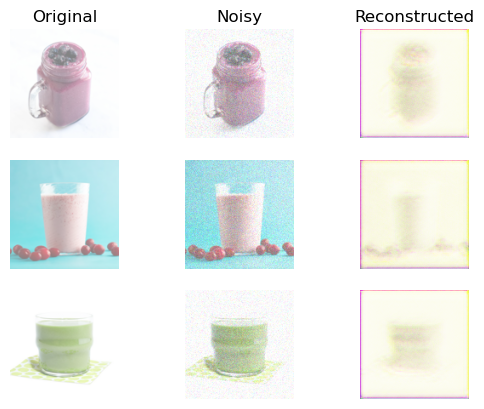

2024-03-03 03:39:18.612063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:19.236404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 11, Loss: 0.0990421362221241


2024-03-03 03:39:19.911735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:20.517351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 12, Loss: 0.10643372684717178


2024-03-03 03:39:21.116516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:21.740731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 13, Loss: 0.11120640113949776


2024-03-03 03:39:22.396695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:22.995046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 14, Loss: 0.09453778341412544


2024-03-03 03:39:23.556671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:24.171102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 15, Loss: 0.09144434705376625


2024-03-03 03:39:24.763890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:25.443210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 16, Loss: 0.10527399554848671


2024-03-03 03:39:26.049652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:26.675693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 17, Loss: 0.09071418270468712


2024-03-03 03:39:27.244453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:27.858366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 18, Loss: 0.09343337267637253


2024-03-03 03:39:28.451198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:29.035244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 19, Loss: 0.08185747265815735


2024-03-03 03:39:29.612933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:30.184131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 20, Loss: 0.10663769766688347
1/1 [==============================] - 0s 163ms/step


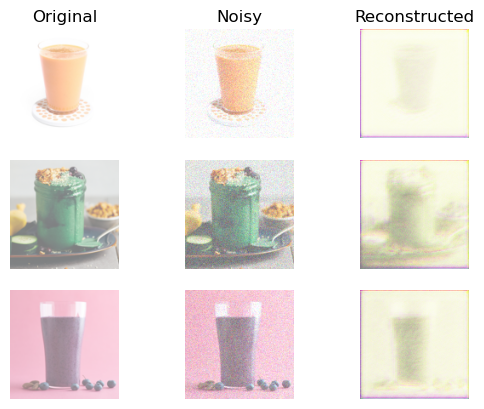

2024-03-03 03:39:31.093958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:31.708933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 21, Loss: 0.08758088946342468


2024-03-03 03:39:32.322871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:32.957935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 22, Loss: 0.07948677986860275


2024-03-03 03:39:33.590268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:34.413490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 23, Loss: 0.07713991776108742


2024-03-03 03:39:35.049672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:35.701622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 24, Loss: 0.0739334300160408


2024-03-03 03:39:36.373817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:37.007344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 25, Loss: 0.06967952102422714


2024-03-03 03:39:37.631901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:38.291638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 26, Loss: 0.07098443806171417


2024-03-03 03:39:39.049004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:39.661462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 27, Loss: 0.07093147560954094


2024-03-03 03:39:40.253184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:40.819196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 28, Loss: 0.06714177131652832


2024-03-03 03:39:41.422894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:42.014125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 29, Loss: 0.0686163567006588


2024-03-03 03:39:42.596407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:43.193979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 30, Loss: 0.06509746983647346
1/1 [==============================] - 0s 170ms/step


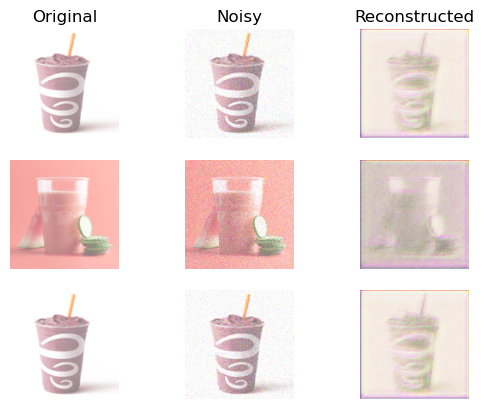

2024-03-03 03:39:44.270351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:44.887247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 31, Loss: 0.06187109649181366


2024-03-03 03:39:45.497589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:46.166270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 32, Loss: 0.0616583488881588


2024-03-03 03:39:46.800470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:47.461001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 33, Loss: 0.06165662221610546


2024-03-03 03:39:48.124907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:48.724286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 34, Loss: 0.06440332904458046


2024-03-03 03:39:49.342413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:49.968438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 35, Loss: 0.05779498070478439


2024-03-03 03:39:50.586355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:51.224893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 36, Loss: 0.05616334639489651


2024-03-03 03:39:51.873186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:52.531029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 37, Loss: 0.0537117924541235


2024-03-03 03:39:53.155535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:53.730431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 38, Loss: 0.05413977801799774


2024-03-03 03:39:54.329234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:54.900183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 39, Loss: 0.047974852845072746


2024-03-03 03:39:55.478966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:56.119380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 40, Loss: 0.04814252257347107
1/1 [==============================] - 0s 163ms/step


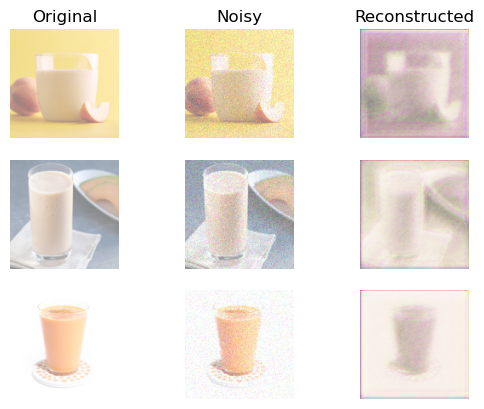

2024-03-03 03:39:57.111109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:57.688049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 41, Loss: 0.05340934917330742


2024-03-03 03:39:58.254840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:58.815272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 42, Loss: 0.050399987027049065


2024-03-03 03:39:59.389273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:39:59.950276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 43, Loss: 0.045665204524993896


2024-03-03 03:40:00.561993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:40:01.202175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 44, Loss: 0.050351448357105255


2024-03-03 03:40:01.815069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:40:02.434086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 45, Loss: 0.05232300981879234


2024-03-03 03:40:03.052973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:40:03.656648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 46, Loss: 0.04333879612386227


2024-03-03 03:40:04.268163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:40:04.834413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 47, Loss: 0.04846215061843395


2024-03-03 03:40:05.406875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:40:06.076252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 48, Loss: 0.04661157540977001


2024-03-03 03:40:06.666762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:40:07.246739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 49, Loss: 0.046208592131733894


2024-03-03 03:40:07.835970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 03:40:08.506812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 50, Loss: 0.046167196705937386
1/1 [==============================] - 0s 183ms/step


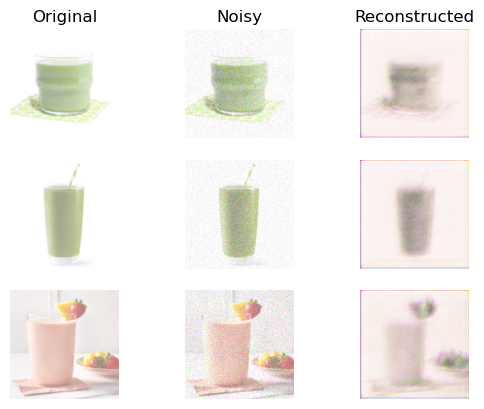

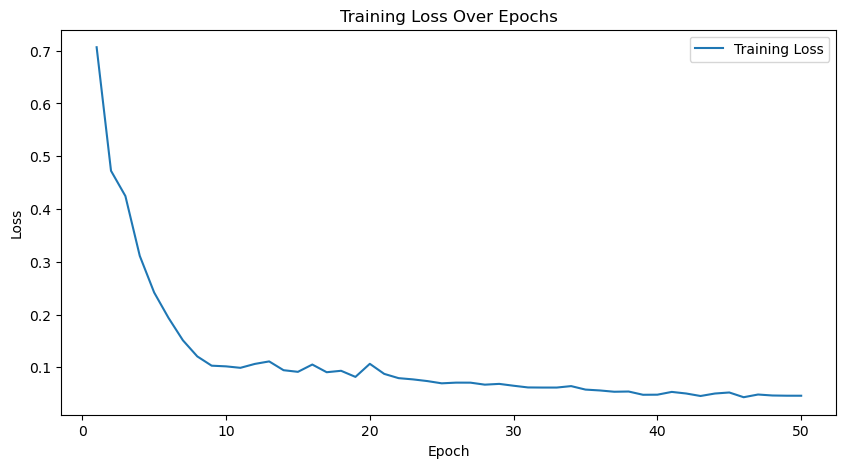

In [20]:
'''Training Execution'''
epochs = 50  # Set the number of epochs
batch_size = 32  # Set the batch size
steps_per_epoch = X_train.shape[0] // batch_size  # Assuming X_train is your dataset

# Placeholder for storing training loss
training_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    for step in range(steps_per_epoch):
        # Sample a batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # Apply the forward diffusion process (add noise)
        noisy_images = add_noise(real_images)
        
        # Train the model on this batch
        loss_value = model.train_on_batch(noisy_images, real_images)
        epoch_loss += loss_value
        
    # Calculate average loss for the epoch
    epoch_loss /= steps_per_epoch
    training_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Optionally display some reconstructed images at intervals
    if (epoch + 1) % 10 == 0:
        # Select a random batch of images
        test_idx = np.random.randint(0, X_train.shape[0], batch_size)
        test_images = X_train[test_idx]
        noisy_test_images = add_noise(test_images)
        reconstructed_images = model.predict(noisy_test_images)
        
        # Plot original, noisy, and reconstructed images
        for i in range(3):
            plt.subplot(3, 3, i*3 + 1)
            plt.imshow(test_images[i] * 0.5 + 0.5)  # Assuming images were normalized to [-1, 1]
            plt.axis('off')
            if i == 0:
                plt.title('Original')
            plt.subplot(3, 3, i*3 + 2)
            plt.imshow(noisy_test_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Noisy')
            plt.subplot(3, 3, i*3 + 3)
            plt.imshow(reconstructed_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
        plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


### Evaluation and Testing
- Generate images using the trained model and compare them to real images to assess quality.

This cell covers:
- Generating images by feeding noise to the trained model and running the reverse diffusion process.
- Displaying the generated images to visually evaluate how well the model has learned to generate smoothie images.
- Comparing with real images from the dataset for a direct quality assessment.

In [ ]:
'''Evaluation and Testing'''
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)  # Assuming images were normalized to [-1, 1]
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Generate images from noise
num_samples = 9  # Number of images to generate
noise = np.random.normal(size=(num_samples, 128, 128, 3))  # Assuming the model inputs are 128x128x3 images
generated_images = model.predict(noise)

# Display generated images
display_images(generated_images, 'Generated Images')

# Optionally, compare with real images from the dataset
# Select a random sample of real images
real_image_indices = np.random.randint(0, X_train.shape[0], num_samples)
real_images = X_train[real_image_indices]

# Display real images
display_images(real_images, 'Real Images')


### Integration Instructions
- Outline how to integrate the model into your Flask application.

To integrate the trained model into your Flask application:
- Save the trained model.
- Load the model in your Flask application.
- Create an endpoint that receives ingredient information, generates a noise vector, and uses the model to generate a smoothie image.
- Return the generated image in response to the request.

In [ ]:
'''Integration Instructions'''
